In [ ]:
# pip install -U jedi==0.17.2

In [1]:
import tensorflow as tf, os, tarfile, json, numpy as np, base64, sagemaker, boto3
from sagemaker.tensorflow import TensorFlowModel
from io import BytesIO
from matplotlib import pyplot as plt
from PIL import Image
from time import sleep
sm_client = boto3.client('sagemaker')
smr_client = boto3.client('sagemaker-runtime')
sm_role = sagemaker.get_execution_role()
sess = sagemaker.session.Session()
bucket = sess.default_bucket()

## 使用するモデルのロードと動作確認

In [2]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

[2021-07-27 08:45:44.204 tensorflow-2-3-cpu-py3-ml-c5-large-e43af8eadf999ccc51decfde869f:3748 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-07-27 08:45:44.329 tensorflow-2-3-cpu-py3-ml-c5-large-e43af8eadf999ccc51decfde869f:3748 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
___________

In [3]:
work_dir = f'{os.getcwd()}/work/'

os.makedirs(work_dir, exist_ok=True)
# サンプル画像をダウンロード
file = tf.keras.utils.get_file(
    f'{work_dir}/mountains.jpg',
    'https://storage.googleapis.com/gcptutorials.com/examples/mountains.jpg')

# 分類クラスをダウンロード
labels_path = tf.keras.utils.get_file(
    f'{work_dir}/ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
labels = list(np.array(open(labels_path).read().splitlines())[1:])

16384/10484 [==============================================] - 0s 0us/step


In [4]:
with open('./code/labels.txt','wt') as f:
    for txt in labels:
        f.write(txt+'\n')

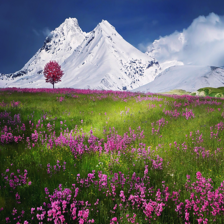

In [5]:
# 画像のresizeと前処理結果の確認
img = Image.open(file).resize((model.input_shape[1],model.input_shape[2]))
img_arr = ((np.array(img)-127.5)/127.5).astype(np.float32).reshape(-1,model.input_shape[1],model.input_shape[2],3)
img

In [6]:
# モデルの動作確認
print(labels[np.argmax(model.predict(img_arr))])

alp


In [7]:
# 保存ディレクトリを指定
model_dir = './mobilenet/0001'

# tar.gz の出力先を指定
tar_dir = 'MyModel'
os.makedirs(tar_dir, exist_ok=True)
tar_name = os.path.join(tar_dir, 'model.tar.gz')

# モデルを SavedModel 形式で保存
model.save(model_dir)

# tar.gz ファイルを出力
with tarfile.open(tar_name, mode='w:gz') as tar:
    tar.add(model_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./mobilenet/0001/assets


INFO:tensorflow:Assets written to: ./mobilenet/0001/assets


In [8]:
# S3 にアップロードして、返り値としてS3のURIを受け取る
model_s3_path = f's3://{bucket}/{tar_dir}'

model_s3_uri = sagemaker.s3.S3Uploader.upload(
    local_path = tar_name,
    desired_s3_uri = model_s3_path
)

print(model_s3_uri)


s3://sagemaker-ap-northeast-1-155580384669/MyModel/model.tar.gz


In [9]:
# Sagemaker SDK でマネージドコンテナの URI を取得
container_image_uri = sagemaker.image_uris.retrieve(
    "tensorflow",  # TensorFlow のマネージドコンテナを利用
    sagemaker.session.Session().boto_region_name, # ECR のリージョンを指定
    version='2.4', # TensorFlow のバージョンを指定
    instance_type = 'ml.m5.large', # インスタンスタイプを指定
    image_scope = 'inference' # 推論コンテナを指定
)

print(container_image_uri)


763104351884.dkr.ecr.ap-northeast-1.amazonaws.com/tensorflow-inference:2.4-cpu


## SageMaker Python SDK で Hosting

In [10]:
model_name = 'MyTFModelFromSMSDK'
endpoint_config_name = model_name + 'Endpoint'
endpoint_name = endpoint_config_name

In [11]:
# モデルとコンテナの指定
tf_model = TensorFlowModel(
    name = model_name,
    model_data=model_s3_uri, # モデルの S3 URI
    role= sm_role, # 割り当てるロール
    image_uri = container_image_uri, # コンテナイメージの S3 URI
)
# デプロイ(endpoint 生成)
predictor = tf_model.deploy(
    endpoint_name=endpoint_name, # エンドポイントの名前
    initial_instance_count=1, # インスタンス数
    instance_type='ml.m5.large', # インスタンスタイプ
)


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating model with name: MyTFModelFromSMSDK
INFO:sagemaker:Creating endpoint with name MyTFModelFromSMSDKEndpoint


-------------!

In [12]:
img = Image.open(file).resize((model.input_shape[1],model.input_shape[2]))
img_arr = ((np.array(img)-127.5)/127.5).astype(np.float32).reshape(-1,model.input_shape[1],model.input_shape[2],3)

In [13]:
result = np.argmax(predictor.predict(img_arr)['predictions'][0])
print(labels[result])

alp


In [14]:
r = sm_client.delete_endpoint(EndpointName=endpoint_name)
r = sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
r = sm_client.delete_model(ModelName=model_name)

## Boto3 で Hosting

In [15]:
model_name = 'MyTFModelAddProcessFromBoto3'
endpoint_config_name = model_name + 'EndpointConfig'
endpoint_name = model_name + 'Endpoint'

In [16]:
response = sm_client.create_model(
    ModelName=model_name,
    PrimaryContainer={
        # SageMaker SDK の時と同じ URI を指定
        'Image': container_image_uri,
        # SageMaker SDK の時と同じ URI を指定
        'ModelDataUrl': model_s3_uri,
    },
    # SageMaker SDK の時と同じ role を指定
    ExecutionRoleArn=sm_role,
)


In [17]:
response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'VariantName': 'AllTrafic',
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
        },
    ],
)


In [18]:
response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
)
while True:
    status = sm_client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    if status in ['InService','RollingBack','SystemUpdating','OutOfService']:
        print('!')
        print(status)
        break
    else:
        print('.',end='')
        sleep(5)

...................!
InService


In [20]:
# リストを文字列にして渡すパターン
request_args = {
    'EndpointName': endpoint_name,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'Body' : str(img_arr.tolist())
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

alp


In [21]:
# jsonにして渡すパターン
request_args = {
    'EndpointName': endpoint_name,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'Body' : json.dumps({"instances": img_arr.tolist()})
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

alp


In [22]:
r = sm_client.delete_endpoint(EndpointName=endpoint_name)
r = sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
r = sm_client.delete_model(ModelName=model_name)

## 前処理/後処理追加
* リスト形式でデータを作成し(た後で json形式に変換し)て predict を行うが、 inference.py を使うことで前処理/後処理を endpoint 側うことも可能。
  * 重い画像の前処理を潤沢なエンドポイントのコンピューティングリソースで実行することで、呼び出し側　(Lambda など)の頻繁かつ長期的に処理するコンピューティングリソースのスペックを低減できる
  * 呼び出し側が前処理を意識せずに実装できるようになる(呼び出し側はデータサイエンティストの領域に入らずに済み、エンドポイントで実行する前処理までをDSの領域にできる）
* 以下を例に実装する。  
    * 前処理の例）画像分類であれば、画像のバイナリデータを base64 エンコーディングしたものを直接送りつけて、 endpoint 側でリストに変換可能
    * 後処理の例）softmax の結果から一番可能性の高い値を取得し、そのインデックスからラベルに変換する

### SageMaker Python SDK でホスティング

In [23]:
!pygmentize ./code/inference.py

import json, numpy as np, tensorflow as tf, base64, os
from pathlib import Path

INPUT_SIZE=(224,224)

with open('/opt/ml/model/code/labels.txt','rt') as f:
    label = f.read().split('\n')[0:-1]

def input_handler(data, context):
    b64_data = json.loads(data.read().decode("utf-8"))['b64_image']
    raw_tensor = tf.io.decode_jpeg(base64.b64decode(b64_data.encode('utf-8')))
    normalization_list = ((tf.image.resize(raw_tensor,(INPUT_SIZE[0],INPUT_SIZE[1])).numpy()-127.5)/127.5).reshape(-1,INPUT_SIZE[0],INPUT_SIZE[1],3).tolist()
    return json.dumps({"instances":normalization_list})
    
def output_handler(data, context):
    response_content_type = context.accept_header
    prediction = label[np.argmax(json.loads(data.content.decode('utf-8'))['predictions'][0])]
    return prediction, response_content_type


In [24]:
model_name = 'MyTFModelAddProcessFromSMSDK'
endpoint_config_name = model_name + 'Endpoint'
endpoint_name = endpoint_config_name

In [25]:
# tar.gz の出力先を指定
tar_dir = 'MyModelAddProcess'
code_dir = './code'
os.makedirs(tar_dir, exist_ok=True)
tar_name = os.path.join(tar_dir, 'model.tar.gz')
with tarfile.open(tar_name, mode='w:gz') as tar:
    tar.add(model_dir)

In [28]:
model_add_process_s3_path = f's3://{bucket}/{tar_dir}'

model_add_process_s3_uri = sagemaker.s3.S3Uploader.upload(
    local_path = tar_name,
    desired_s3_uri = model_add_process_s3_path
)
print(model_add_process_s3_uri)

s3://sagemaker-ap-northeast-1-155580384669/MyModelAddProcess/model.tar.gz


#### inference.py と必要なファイルの設定
* entry_point 引数で `inference.py` (名前固定)を指定すると `input_handler` と `output_handler` を推論前後に実行してくれる
* 必要なモジュール等がある場合は `source_dir` 引数に格納してあるディレクトリを指定すると一緒に読み込むが、 inference.py が `source_dir` のルートに存在する必要がある
* ホスティング先の展開ディレクトリは `/opt/ml/model/code` になるので、テキストファイルを読み込む時は絶対パスで指定するとよい（カレントディレクトリは `/sagemaker` で実行される）

In [29]:
# モデルとコンテナの指定
tf_model = TensorFlowModel(
    name = model_name,
    model_data=model_add_process_s3_uri, # モデルの S3 URI
    role= sm_role, # 割り当てるロール
    image_uri = container_image_uri, # コンテナイメージの S3 URI
    entry_point = './code/inference.py',
    source_dir = './code/'
)
# デプロイ(endpoint 生成)
predictor = tf_model.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1, # インスタンス数
    instance_type='ml.m5.xlarge', # インスタンスタイプ
)


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating model with name: MyTFModelAddProcessFromSMSDK
INFO:sagemaker:Creating endpoint with name MyTFModelAddProcessFromSMSDKEndpoint


-----------!

In [31]:
# 推論
with open('./work/mountains.jpg', 'rb') as img:
    data = img.read()
bio = BytesIO()
bio.write(data)
b64_data = base64.b64encode(bio.getvalue()).decode('utf-8')
json_b64 = json.dumps({'b64_image':b64_data})
request_args = {
    'EndpointName': endpoint_name,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'Body' : json_b64
}
response = smr_client.invoke_endpoint(**request_args)
print(response['Body'].read().decode('utf-8'))

alp


In [32]:
# すでにあった場合の削除
r = sm_client.delete_endpoint(EndpointName=endpoint_name)
r = sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
r = sm_client.delete_model(ModelName=model_name)

### Boto3 でホスティングと推論

In [33]:
model_name = 'MyTFModelAddProcessFromBoto3'
endpoint_config_name = model_name + 'EndpointConfig'
endpoint_name = model_name + 'Endpoint'

#### inference.py 他をmodel.tar.gz に同包
boto3 から endpoint を作成する場合は、SageMaker SDK のように `entry_point` や `source_dir` の設定ができないため、 必要なファイルは予め `model.tar.gz` に一緒に入れる必要がある  
(SageMaker SDK の場合は裏側で自動で `inference.py` などを model.tar.gz に再度固めて s3 にアップロードしてくれている)

In [34]:
# model.tar.gz にモデルなどを固める
tar_dir = 'MyModelAddProcess'
code_dir = './code'
os.makedirs(tar_dir, exist_ok=True)
tar_name = os.path.join(tar_dir, 'model.tar.gz')
with tarfile.open(tar_name, mode='w:gz') as tar:
    tar.add(model_dir)
    tar.add(code_dir) # inference.py などを同包

In [37]:
model_add_process_s3_path = f's3://{bucket}/{tar_dir}'

model_add_process_s3_uri = sagemaker.s3.S3Uploader.upload(
    local_path = tar_name,
    desired_s3_uri = model_add_process_s3_path
)
print(model_add_process_s3_uri)

s3://sagemaker-ap-northeast-1-155580384669/MyModelAddProcess/model.tar.gz


In [39]:
response = sm_client.create_model(
    ModelName=model_name,
    PrimaryContainer={
        # SageMaker SDK の時と同じ URI を指定
        'Image': container_image_uri,
        # SageMaker SDK の時と同じ URI を指定
        'ModelDataUrl': model_add_process_s3_uri,
    },
    # SageMaker SDK の時と同じ role を指定
    ExecutionRoleArn=sm_role,
)
response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'VariantName': 'AllTrafic',
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
        },
    ],
)
response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
)

while True:
    status = sm_client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    if status in ['InService','RollingBack','SystemUpdating','OutOfService']:
        print('!')
        print(status)
        break
    else:
        print('.',end='')
        sleep(5)

...............................................................!
InService


In [40]:
# 推論
request_args = {
    'EndpointName': endpoint_name,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'Body' : json_b64
}
response = smr_client.invoke_endpoint(**request_args)
print(response['Body'].read().decode('utf-8'))

alp


In [92]:
# 削除
r = sm_client.delete_endpoint(EndpointName=endpoint_name)
r = sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
r = sm_client.delete_model(ModelName=model_name)

## マルチモデルエンドポイント
`model.tar.gz` に固める際に、

### モデル準備(mobilenetv2)

In [42]:
model2 = tf.keras.applications.mobilenet_v2.MobileNetV2()
print(model2.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [43]:
# モデルの動作確認(v1との比較)
# mobilenet
prediction = model.predict(img_arr)[0]
print(prediction[np.argmax(prediction)],labels[np.argmax(prediction)])
# mobilenetV2
prediction = model2.predict(img_arr)[0]
print(prediction[np.argmax(prediction)],labels[np.argmax(prediction)])

0.74999946 alp
0.45929122 alp


In [ ]:
os.chdir

In [89]:
# 保存ディレクトリを指定
model2_dir = './mobilenetv2/0001'

# mobilenetv2.tar.gz の出力先を指定
tar_dir = 'MyMultiModel'
os.makedirs(tar_dir, exist_ok=True)
tar_name = os.path.join(tar_dir, 'mobilenetv2.tar.gz')

# モデルを SavedModel 形式で保存
model2.save(model2_dir)

# tar.gz ファイルを出力
with tarfile.open(tar_name, mode='w:gz') as tar:
    tar.add(model2_dir, arcname="0001")

# mobilenet.tar.gz の出力先を指定
tar_name = os.path.join(tar_dir, 'mobilenet.tar.gz')
# tar.gz ファイルを出力
with tarfile.open(tar_name, mode='w:gz') as tar:
    tar.add(model_dir, arcname="0001")

INFO:tensorflow:Assets written to: ./mobilenetv2/0001/assets


INFO:tensorflow:Assets written to: ./mobilenetv2/0001/assets


In [90]:
multi_model_s3_path = f's3://{bucket}/{tar_dir}/'

!aws s3 cp ./MyMultiModel/ {multi_model_s3_path} --recursive

upload: MyMultiModel/mobilenetv2.tar.gz to s3://sagemaker-ap-northeast-1-155580384669/MyMultiModel/mobilenetv2.tar.gz
upload: MyMultiModel/mobilenet.tar.gz to s3://sagemaker-ap-northeast-1-155580384669/MyMultiModel/mobilenet.tar.gz


In [91]:
model_name = 'MyMultiModel'
endpoint_config_name = model_name + 'EndpointConfig'
endpoint_name = model_name + 'Endpoint'

In [93]:
response = sm_client.create_model(
    ModelName=model_name,
        PrimaryContainer={
        'Image': container_image_uri,
        'Mode':'MultiModel',
        'ModelDataUrl': multi_model_s3_path, # tar.gz を配置している S3 パスを指定
    },
    ExecutionRoleArn=sm_role,
)

In [94]:
response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'VariantName': 'AllTrafic',
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
        },
    ],
)

In [ ]:
response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
)

while True:
    status = sm_client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    if status in ['InService','RollingBack','SystemUpdating','OutOfService']:
        print('!')
        print(status)
        break
    else:
        print('.',end='')
        sleep(5)

...............................................

In [126]:
# 推論
request_args = {
    'EndpointName': endpoint_name,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'TargetModel' : 'mobilenet.tar.gz',
    'Body' : json.dumps({"instances": img_arr.tolist()})
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

alp 0.749999464


In [127]:
# 推論
request_args = {
    'EndpointName': endpoint_name,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'TargetModel' : 'mobilenetv2.tar.gz',
    'Body' : json.dumps({"instances": img_arr.tolist()})
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

alp 0.45929122


In [128]:
r = sm_client.delete_endpoint(EndpointName=endpoint_name)
r = sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
r = sm_client.delete_model(ModelName=model_name)